In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)
from google.colab import files
import io
import pandas as pd
import math 


2.2.0-rc4


In [4]:
uploaded = files.upload()

Saving sp500.csv to sp500.csv


In [0]:
sp500= pd.read_csv(io.BytesIO(uploaded['sp500.csv']))

In [7]:
sp500['Close'].isnull().sum()

0

In [9]:
sp500

,Date,Open,High,Low,Close,Adj Close,Volume
0,1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0
1,1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0
2,1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0
3,1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0
4,1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0
...,...,...,...,...,...,...,...
23189,2020-04-28,2909.959961,2921.149902,2860.709961,2863.389893,2863.389893,5672880000
23190,2020-04-29,2918.459961,2954.860107,2912.159912,2939.510010,2939.510010,6620140000
23191,2020-04-30,2930.909912,2930.909912,2892.469971,2912.429932,2912.429932,6523120000
23192,2020-05-01,2869.090088,2869.090088,2821.610107,2830.709961,2830.709961,4753160000


In [0]:
#walmart['ret'] = walmart.close.pct_change(1).mul(100)

In [0]:
sp500['ret'] = sp500.Close.pct_change(1).mul(100)

In [39]:
sp500['ret'].shape

(23194,)

In [41]:
#using returns instead of close price
series = sp500['ret']
print(series)
type(series)
time = np.arange(0,23194,1)
print(time.shape,series.shape)

0             NaN
1        0.566251
2       -0.225231
3       -0.959368
4        0.626786
           ...   
23189   -0.524238
23190    2.658392
23191   -0.921245
23192   -2.805903
23193    0.424983
Name: ret, Length: 23194, dtype: float64
(23194,) (23194,)


In [42]:
print(series.shape)

(23194,)


In [45]:
#adjusting series for using return
series = series[1:]
##slicing time for uisng wih returns

print(time.shape)
print(series.shape)

(23192,)
(23191,)


In [0]:
time = np.arange(0,23191,1)

(23191,)

In [0]:
series = pd.Series.to_numpy(series)

In [49]:
series.shape

(23191,)

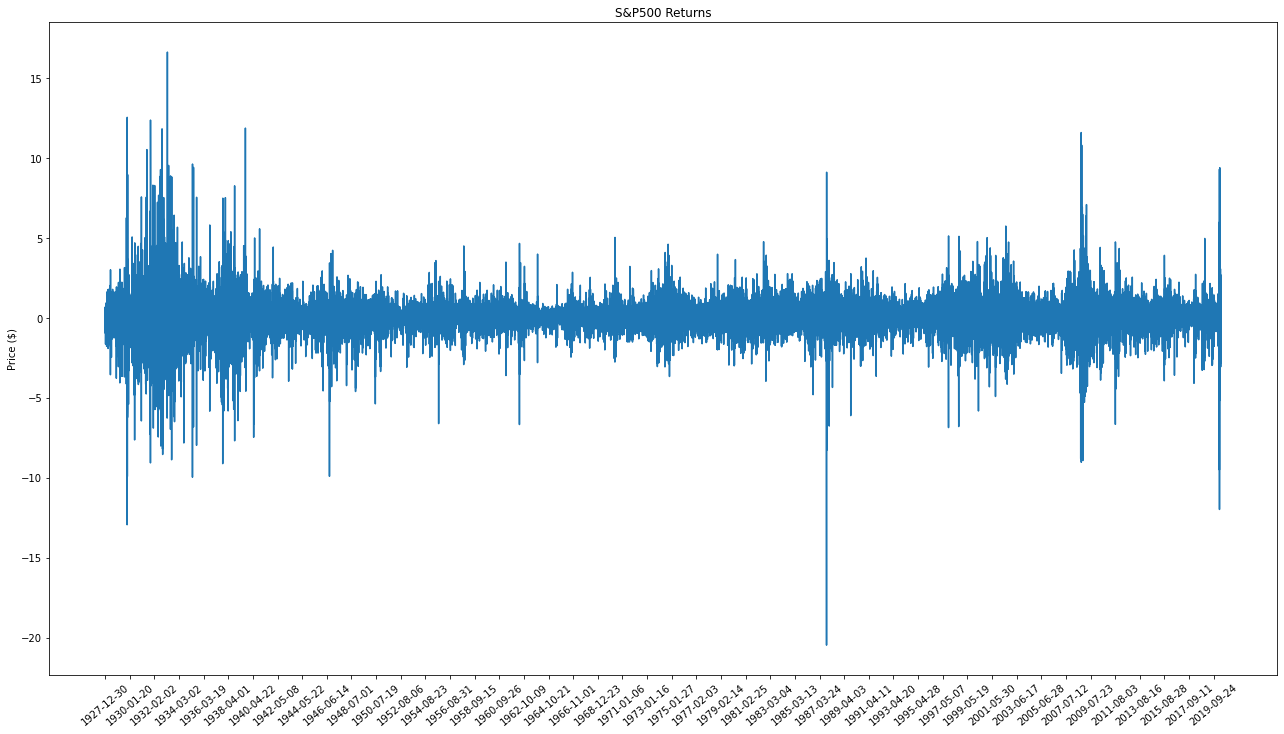

In [50]:
##plot the price
df = sp500.copy()
plt.figure(figsize = (22,12))
plt.plot(sp500.index, sp500['ret'])
plt.title('S&P500 Returns')
plt.xticks(range(0,sp500.shape[0],512),sp500['Date'].loc[::512],rotation=40)
plt.ylabel('Price ($)');
plt.show()


In [0]:
series = series[18000:]
time= time[18000:]

In [52]:
series.shape

(5191,)

In [53]:
time.shape

(5191,)

In [0]:
split_time = 3600
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size =64
batch_size = 128
shuffle_buffer_size = 1000

In [56]:
print(x_train.shape)
print(x_valid.shape)

(3600,)
(1591,)


In [60]:
print(type(x_train))
print(type(time))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size =64
batch_size = 128

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  #tf.keras.layers.Lambda(lambda x: x * 10.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.mean_squared_logarithmic_error,
              optimizer=optimizer,
              metrics=["mse"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
28/28 [==============================] - 1s 27ms/step - loss: 0.2216 - mse: 1.7232 - lr: 1.0000e-08
Epoch 2/100
28/28 [==============================] - 1s 28ms/step - loss: 0.2216 - mse: 1.7232 - lr: 1.1220e-08
Epoch 3/100
28/28 [==============================] - 1s 28ms/step - loss: 0.2216 - mse: 1.7232 - lr: 1.2589e-08
Epoch 4/100
28/28 [==============================] - 1s 29ms/step - loss: 0.2216 - mse: 1.7232 - lr: 1.4125e-08
Epoch 5/100
28/28 [==============================] - 1s 29ms/step - loss: 0.2216 - mse: 1.7232 - lr: 1.5849e-08
Epoch 6/100
28/28 [==============================] - 1s 29ms/step - loss: 0.2216 - mse: 1.7232 - lr: 1.7783e-08
Epoch 7/100
28/28 [==============================] - 1s 30ms/step - loss: 0.2216 - mse: 1.7232 - lr: 1.9953e-08
Epoch 8/100
28/28 [==============================] - 1s 29ms/step - loss: 0.2216 - mse: 1.7232 - lr: 2.2387e-08
Epoch 9/100
28/28 [==============================] - 1s 29ms/step - loss: 0.2216 - mse: 1.7232 - lr: 2.5

KeyboardInterrupt: ignored

(1e-08, 0.0001, 0.0, 30.0)

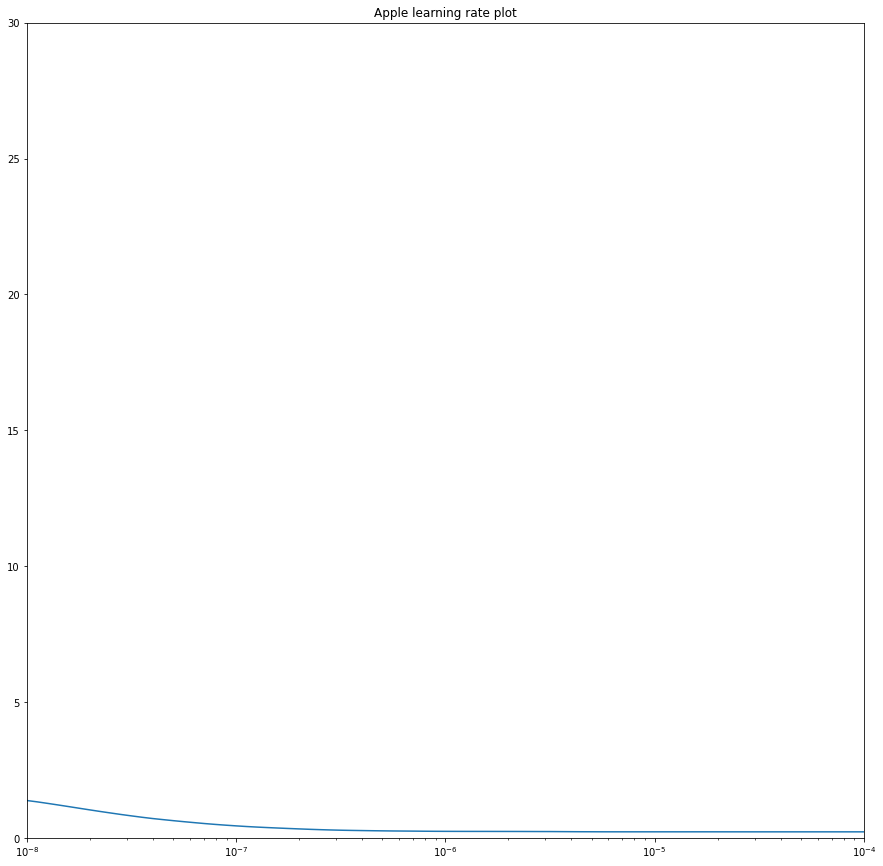

In [80]:
plt.figure(figsize=(15,15))
plt.semilogx(history.history["lr"], history.history["loss"])
plt.title("Apple learning rate plot")
plt.axis([1e-8, 1e-4, 0, 30])

In [85]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size =48
batch_size = 100
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 2.0)
])


model.compile(loss=tf.keras.losses.mean_squared_logarithmic_error, optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mse"])
history = model.fit(dataset,epochs=300,verbose=1)

Epoch 1/300
36/36 [==============================] - 1s 22ms/step - loss: 0.2159 - mse: 1.7213
Epoch 2/300
36/36 [==============================] - 1s 23ms/step - loss: 0.2121 - mse: 1.7211
Epoch 3/300
36/36 [==============================] - 1s 23ms/step - loss: 0.2058 - mse: 1.7214
Epoch 4/300
36/36 [==============================] - 1s 23ms/step - loss: 0.1977 - mse: 1.7229
Epoch 5/300
36/36 [==============================] - 1s 23ms/step - loss: 0.1895 - mse: 1.7255
Epoch 6/300
36/36 [==============================] - 1s 23ms/step - loss: 0.1821 - mse: 1.7279
Epoch 7/300
36/36 [==============================] - 1s 24ms/step - loss: 0.1762 - mse: 1.7319
Epoch 8/300
36/36 [==============================] - 1s 23ms/step - loss: 0.1713 - mse: 1.7356
Epoch 9/300
36/36 [==============================] - 1s 23ms/step - loss: 0.1673 - mse: 1.7398
Epoch 10/300
36/36 [==============================] - 1s 23ms/step - loss: 0.1641 - mse: 1.7441
Epoch 11/300
36/36 [=============================

KeyboardInterrupt: ignored

In [0]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

In [75]:
x_valid.shape

(1591,)

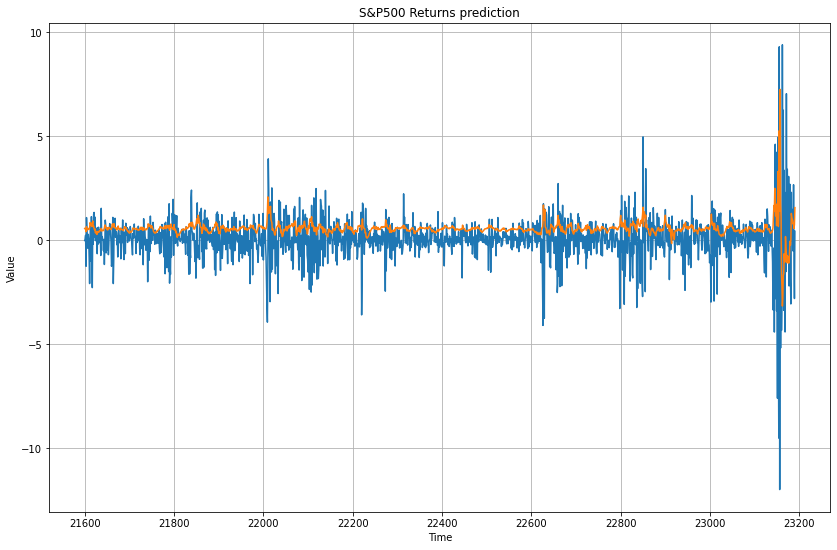

In [74]:
plt.figure(figsize=(14, 9))
plt.title("S&P500 Returns prediction")
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [76]:
tf.keras.metrics.mean_squared_error(x_valid, results).numpy()

1.5731776

In [77]:
print("RMSE= " , math.sqrt(tf.keras.metrics.mean_squared_error(x_valid, results).numpy()))

RMSE=  1.254263758571164


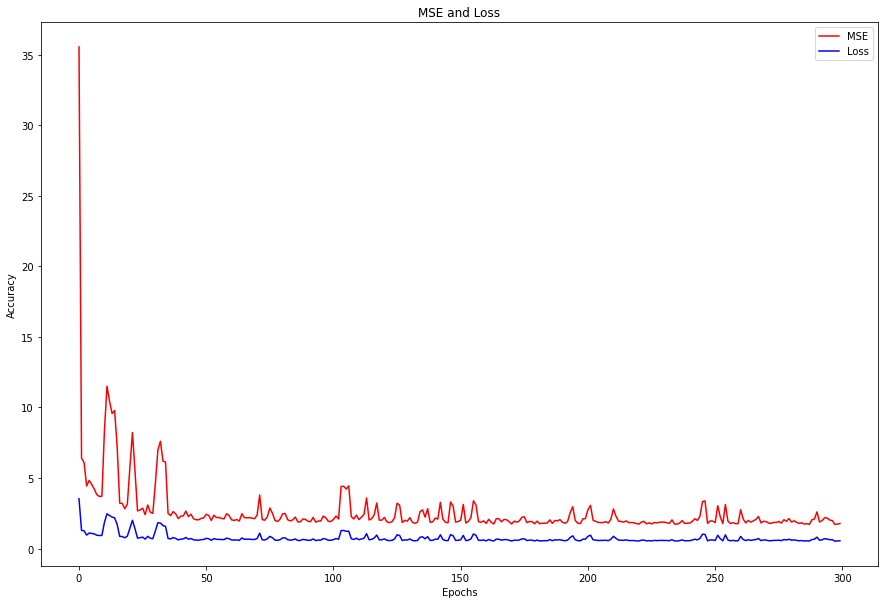

<Figure size 432x288 with 0 Axes>

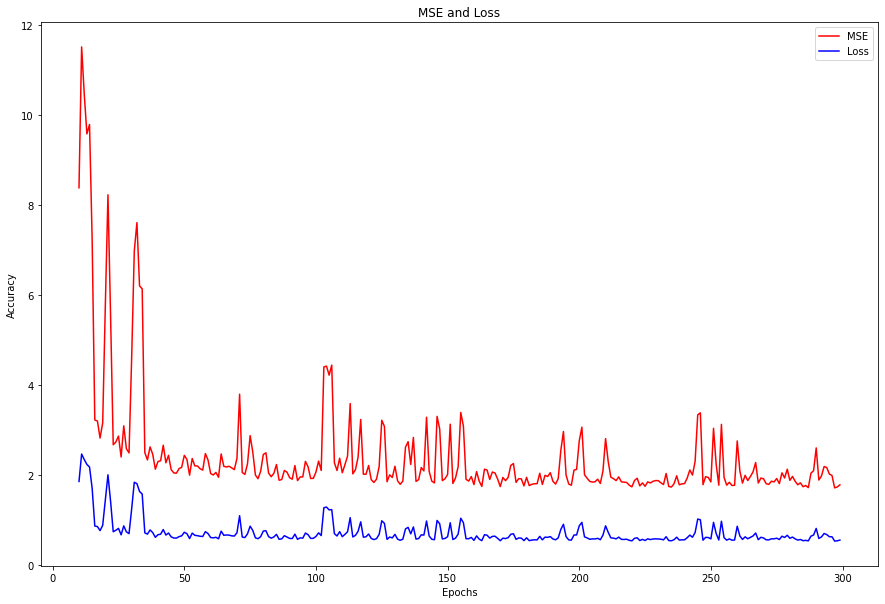

In [78]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mse=history.history['mse']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.figure(figsize=(15,10))
plt.plot(epochs, mse, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MSE", "Loss"])

plt.figure()

epochs_zoom = epochs[10:]
mse_zoom = mse[10:]
loss_zoom = loss[10:300]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.figure(figsize=(15,10))
plt.plot(epochs_zoom, mse_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MSE", "Loss"])

